In [42]:
import pandas as pd
import numpy as np

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolfiles import SDWriter 

In [43]:
# First read the scoring Excel file
df_mmgbsa = pd.read_excel("Rescoring_with_RMSD_and_DIST2.xlsx")
df_mmgbsa.shape

(250, 13)

In [44]:
df_mmgbsa.dtypes

index               object
Name                object
ChemPlp            float64
MM-GBSA Nwat=0      object
STDEV               object
MM-GBSA Nwat=30     object
STDEV.1             object
MM-GBSA Nwat=60     object
STDEV.2             object
ST.DEV < 10%        object
RMSD LIG < 2        object
DIST < 5            object
DIST < 3.5          object
dtype: object

In [45]:
df_mmgbsa.head()

,index,Name,ChemPlp,MM-GBSA Nwat=0,STDEV,MM-GBSA Nwat=30,STDEV.1,MM-GBSA Nwat=60,STDEV.2,ST.DEV < 10%,RMSD LIG < 2,DIST < 5,DIST < 3.5
0,ligand513,PAU-WEI-b9b-9,-109.7120,-42.2937,4.8564,-77.6467,7.3639,-93.0126,7.1343,Y,Y,Y,N
1,ligand515,PAU-WEI-f73-1,-101.0730,-38.8862,5.3589,-77.1676,5.5985,-84.0754,5.6447,Y,Y,Y,N
2,ligand365,MAK-UNK-af8-21,-104.8990,-27.5286,3.2128,-71.9748,5.0916,-81.1969,5.2883,Y,Y,Y,N
3,ligand249,JAN-LUN-04a-7,-93.5547,-38.7691,3.6385,-71.4576,6.6709,-88.3512,7.1682,Y,Y,Y,N
4,ligand205,HAN-NEW-5f5-4,-104.2970,-40.4513,3.069,-70.8651,5.5683,-77.9208,6.2077,Y,Y,Y,N


In [46]:
# Now ready the original CSV file containing the source info
df_source = pd.read_csv("submissions.csv")
df_source.shape

(4539, 28)

In [47]:
df_source.dtypes

SMILES                      object
CID                         object
old_CID                     object
creator                     object
rationale                   object
fragments                   object
link                        object
real_space                  object
extended_real_space         object
SCR                         object
BB                          object
covalent_frag                 bool
covalent_warhead              bool
acrylamide                    bool
acrylamide_adduct             bool
chloroacetamide               bool
chloroacetamide_adduct        bool
vinylsulfonamide              bool
vinylsulfonamide_adduct       bool
nitrile                       bool
nitrile_adduct                bool
in_molport_or_mcule           bool
in_emolecules                 bool
MW                         float64
cLogP                      float64
HBD                          int64
HBA                          int64
TPSA                       float64
dtype: object

In [48]:
df_source.head()

,SMILES,CID,old_CID,creator,rationale,fragments,link,real_space,extended_real_space,SCR,...,vinylsulfonamide_adduct,nitrile,nitrile_adduct,in_molport_or_mcule,in_emolecules,MW,cLogP,HBD,HBA,TPSA
0,CN1CCCC1c1cccnc1,KTA-UNK-dac325de-1,K. -UNK-dac-1,K. Takahashi,these compounds has similar Hansen Solubility ...,x0072,https://covid.postera.ai/covid/submissions/dac...,False,False,False,...,False,False,False,False,True,162.236,1.8483,0,2,16.13
1,c1ccc2[nH]ccc2c1,KTA-UNK-dac325de-2,K. -UNK-dac-2,K. Takahashi,these compounds has similar Hansen Solubility ...,x0072,https://covid.postera.ai/covid/submissions/dac...,False,False,Z3371365238,...,False,False,False,False,False,117.151,2.1679,1,0,15.79
2,c1ccncc1,KTA-UNK-dac325de-3,K. -UNK-dac-3,K. Takahashi,these compounds has similar Hansen Solubility ...,x0072,https://covid.postera.ai/covid/submissions/dac...,False,False,Z1741957307,...,False,False,False,False,False,79.102,1.0816,0,1,12.89
3,CC(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cc(F)cc12,ELE-IMP-dfb36048-1,ELE-IMP-dfb-1,"Elena De Vita, Imperial College",Merging by eye of non-covalent fragments evolv...,"x0072,x0104,x0161",https://covid.postera.ai/covid/submissions/dfb...,False,False,False,...,False,False,False,False,False,341.408,1.0773,3,3,91.06
4,CC(=O)NCCc1c[nH]c2c(CCNS(C)(=O)=O)cccc12,ELE-IMP-dfb36048-2,ELE-IMP-dfb-2,"Elena De Vita, Imperial College",Merging by eye of non-covalent fragments evolv...,"x0072,x0104,x0161",https://covid.postera.ai/covid/submissions/dfb...,False,False,False,...,False,False,False,False,False,323.418,0.9382,3,3,91.06


In [49]:
# Now read the SDF
df_sdf = PandasTools.LoadSDF('top250_with_scores_noH.sdf', molColName='Molecule', embedProps=True)
df_sdf.shape

(250, 15)

In [50]:
df_sdf.dtypes

index              object
Name               object
ChemPlp            object
MM-GBSA Nwat=0     object
STDEV0             object
MM-GBSA Nwat=30    object
STDEV30            object
MM-GBSA Nwat=60    object
STDEV60            object
ST.DEV < 10%       object
RMSD LIG < 2       object
DIST < 5           object
DIST < 3.5         object
ID                 object
Molecule           object
dtype: object

,index,Name,ChemPlp,MM-GBSA Nwat=0,STDEV0,MM-GBSA Nwat=30,STDEV30,MM-GBSA Nwat=60,STDEV60,ST.DEV < 10%,RMSD LIG < 2,DIST < 5,DIST < 3.5,ID,Molecule
0,ligand513,PAU-WEI-b9b-9,-109.712,-42.293701,4.8564,-77.646698,7.3639002,-93.012604,7.1343002,Y,Y,Y,N,ClCC(=O)N1CC[N+H](C(CCc2ccc(C(F)(F)F)cc2)c2c3[...,
1,ligand515,PAU-WEI-f73-1,-101.073,-38.8862,5.3589001,-77.167603,5.5984998,-84.075401,5.6447001,Y,Y,Y,N,Brc1sc(C([N+H]2CCN(C(=O)CCl)CC2)c2c3[nH]cc(CCN...,
2,ligand365,MAK-UNK-af8-21,-104.899,-27.528601,3.2128,-71.9748,5.0915999,-81.196899,5.2883,Y,Y,Y,N,ClCC(=O)N1CC[N+H](Cc2cc(C3CC(O)C(OC#N)C([N+H2]...,
3,ligand249,JAN-LUN-04a-7,-93.554703,-38.7691,3.6385,-71.457603,6.6708999,-88.351196,7.1682,Y,Y,Y,N,ClCC(=O)N1CC(c2c(NC(=O)Nc3cc(CCCC(=O)[O-])cnc3...,
4,ligand205,HAN-NEW-5f5-4,-104.297,-40.451302,3.069,-70.865097,5.5682998,-77.920799,6.2076998,Y,Y,Y,N,ClCC(=O)N1CC(CCCc2c3[nH]cc(CCNC(=O)C)c3ccc2)N(...,

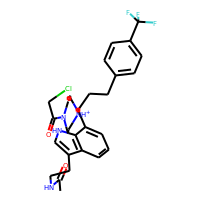
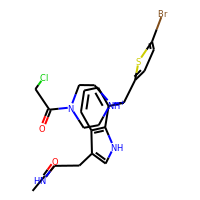
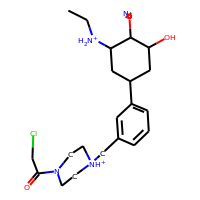
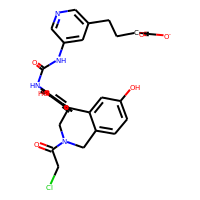
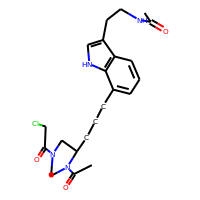

In [51]:
df_sdf.head()

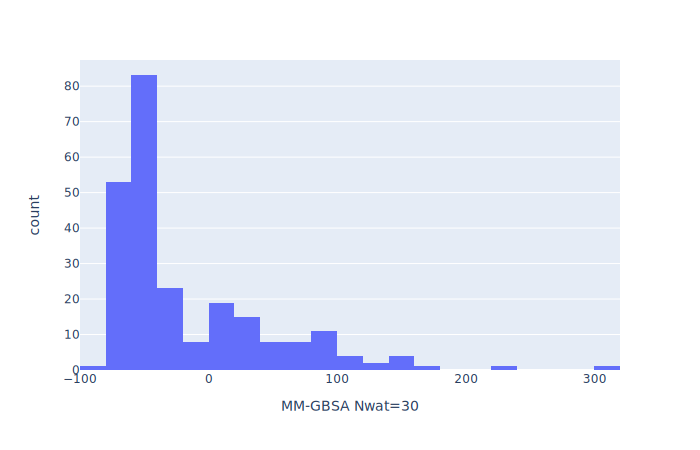

In [52]:
fig = px.histogram(df_sdf, x="MM-GBSA Nwat=30")
fig.show(renderer='svg')

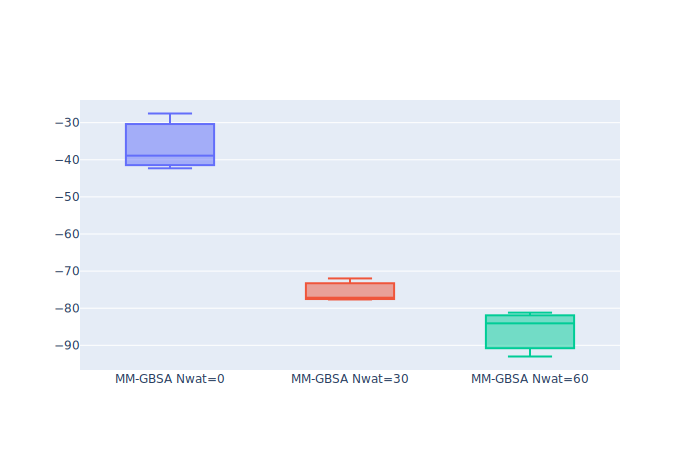

In [53]:
# Score distributions wwith differnt waters

fig = go.Figure()
for col in ['MM-GBSA Nwat=0', 'MM-GBSA Nwat=30', 'MM-GBSA Nwat=60']:
    xs = []
    for i in range(3):
        xs.append(col)
    fig.add_trace(go.Box(x=xs, y=df_sdf[col], showlegend=False))
fig.show(renderer='svg')

In [54]:
mol0 = Chem.MolFromSmiles('C')
mol0.SetProp('_Name', 'ver_1.2')
mol0.SetProp('submitter_name', 'Alessandro Contini')
mol0.SetProp('submitter_email', 'alessandro.contini@unimi.it')
mol0.SetProp('submitter_institution', 'Universtity of Milan')
mol0.SetProp('generation_date', '2020-04-19')
mol0.SetProp('method', 'Nwat MM-GBSA covalent run 1')
mol0.SetProp('original SMILES', 'molecule smiles')
mol0.SetProp('ref_url', 'https://discuss.postera.ai/t/results-from-nwat-mmgbsa-workflow-on-covalent-warheads/1225')
mol0.SetProp('ref_mols', 'reference molecules')
mol0.SetProp('ref_pdb', 'All ligands were evaluated against Mpro-x0830_0')
mol0.SetProp('Name', 'Moonshot compound ID (text)')
mol0.SetProp('ChemPlp', 'ChemPlp score from PLANTS docking (float)')
mol0.SetProp('MM-GBSA Nwat=0', 'Nwat MM-GBSA with 0 waters (float)')
mol0.SetProp('STDEV0', 'Std Dev for 0 waters (float)')
mol0.SetProp('MM-GBSA Nwat=30', 'Nwat MM-GBSA with 30 waters (float)')
mol0.SetProp('STDEV30', 'Std Dev for 30 waters (float)')
mol0.SetProp('MM-GBSA Nwat=60', 'Nwat MM-GBSA with 60 waters (float)')
mol0.SetProp('STDEV60', 'Std Dev for 60 waters (float)')
mol0.SetProp('ST.DEV < 10%', 'Is the Std Dev less than 10% for the nwat=30 data (boolean)')
mol0.SetProp('RMSD LIG < 2', 'Is the RMSD of the ligand over the MD run less that 2A (boolean)')
mol0.SetProp('DIST < 5', 'In the docking pose is the distance of the warhead to the Cys145 thiol less than 5A (boolean)')
mol0.SetProp('DIST < 3.5', 'In the docking pose is the distance of the warhead to the Cys145 thiol less than 3.5A (boolean)')

In [59]:
def fix_mol_codes(x):
    if x == 'x1420':
        return 'x1392_0'
    if x == 'x0748':
        return 'x1382_0'
    else:
        return x + '_0'

def fix_molecule(row):
    m = row['Molecule']
    m.SetProp('ref_pdb', 'x0830_0')
    
    # fetch the corresponding row of the df_source data frame
    # kludge 1: the old CIDs were inconsistent and have been replaced by new ones,
    # but the data in this SDF uses the old CIDs so we need to switch them.
    old_cid = row['Name']
    df = df_source[df_source['old_CID'] == old_cid]
    
    new_cid = df['CID'].array[0]
    m.SetProp('_Name', new_cid)
    
    # handle the fragments data. 
    # kludge 2: these are formatted like x0072,x0104,x0161
    # but the required format is x0072_0,x0104_0,x0161_0
    # kludge 3: x1420_0 has been replaced with x1392_0 so we need to fix this
    # kludge 4: x0748_0 has been replaced with x1382_0
    fragments = df['fragments']
    if len(fragments) > 0:
        items = fragments.array[0].split(',')
        fixed_items = map(fix_mol_codes , items)
        m.SetProp('ref_mols', ','.join(fixed_items))
    
    # now handle the smiles
    smiles = df['SMILES']
    if len(smiles) > 0:
        m.SetProp('original SMILES', smiles.array[0])
        
    return m

In [60]:
w = Chem.SDWriter('collated.sdf')
w.write(mol0)

for index, row in df_sdf.iterrows():
    mol = fix_molecule(row)
    w.write(mol)
    

w.close()